# Crop Yield Analysis and Prediction
This notebook presents an analysis of crop yields based on various factors like pesticide usage and average temperature. It includes data preparation, exploratory data analysis, model training, and a user interface for yield prediction.


## Data Import and Preliminary Processing
This section involves importing the necessary libraries and the dataset, followed by initial data processing steps such as selecting relevant columns and renaming them for better readability.



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import ipywidgets as widgets
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Select columns to load into DF - don't need the index col
columns_to_read = ['Area', 'Item', 'Year', 'hg/ha_yield','pesticides_tonnes', 'avg_temp']
yield_df = pd.read_csv('../data/processed/yield_avg_cleaned.csv', usecols=columns_to_read)

# Rename columns for better readability and consistency
yield_df.rename(columns = {
    'Area' : 'Country',
    'Item' : 'Crop',
    'hg/ha_yield' : 'Hg/Ha Yield',
    'pesticides_tonnes' : 'Pesticide Tonnes',
    'avg_temp': 'Avg Temp'
}, inplace = True)

yield_df.head()

,Country,Crop,Year,Hg/Ha Yield,Pesticide Tonnes,Avg Temp
0,Albania,Maize,1990,36613,121.0,16.37
1,Albania,Potatoes,1990,66667,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,121.0,16.37
3,Albania,Sorghum,1990,12500,121.0,16.37
4,Albania,Soybeans,1990,7000,121.0,16.37


## Exploratory Data Analysis
This part explores the dataset through various visualizations to understand trends and patterns in crop yields over the year, and how factors like pesticide usage and average temperature might influence these yields.


#### Crop Yield Over The Years (Hg/Ha)



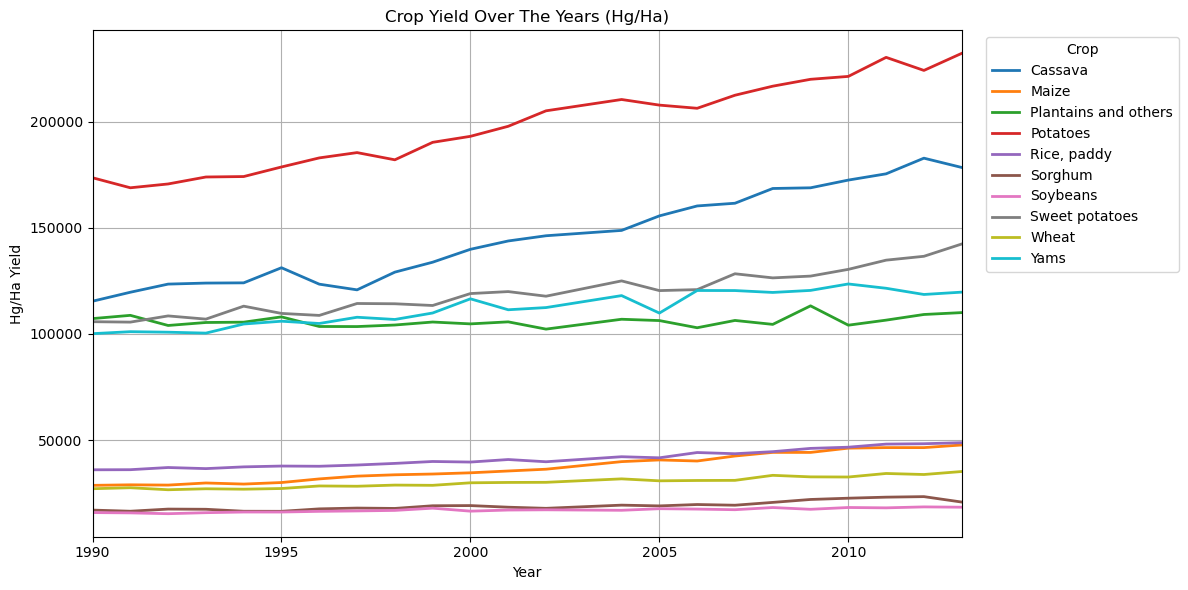

In [3]:
# %matplotlib inline #uncomment if graph does not display

# Create pivot table for mean yield by year and crop
pivot_yield_df = yield_df.pivot_table(index='Year', columns='Crop', values='Hg/Ha Yield', aggfunc='mean')

# Plot using Pandas built-in functionality for a more concise and efficient approach
ax = pivot_yield_df.plot(figsize=(12, 6), linewidth=2, title='Crop Yield Over The Years (Hg/Ha)')
ax.set_xlabel('Year')
ax.set_ylabel('Hg/Ha Yield')
ax.grid(True)
plt.legend(title='Crop', bbox_to_anchor=(1.02, 1), loc = 'upper left')
ax.set_xlim(left=pivot_yield_df.index.min(), right=pivot_yield_df.index.max())
plt.tight_layout()
plt.show()

#### Crop Yield plot based on average amount of pesticide tonnes, and average temperature

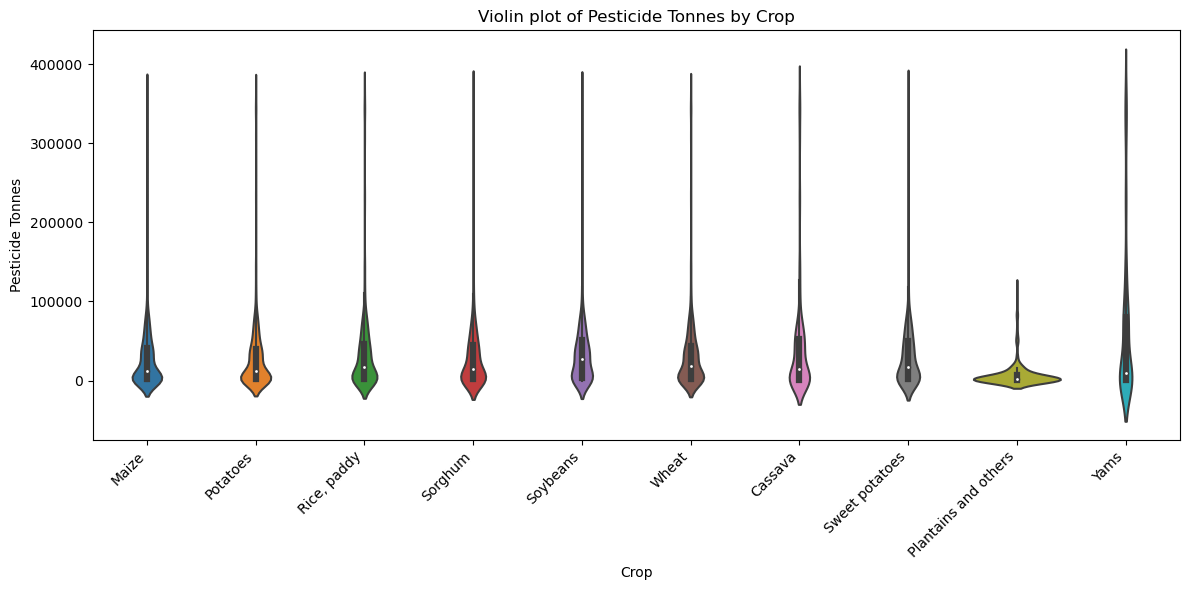

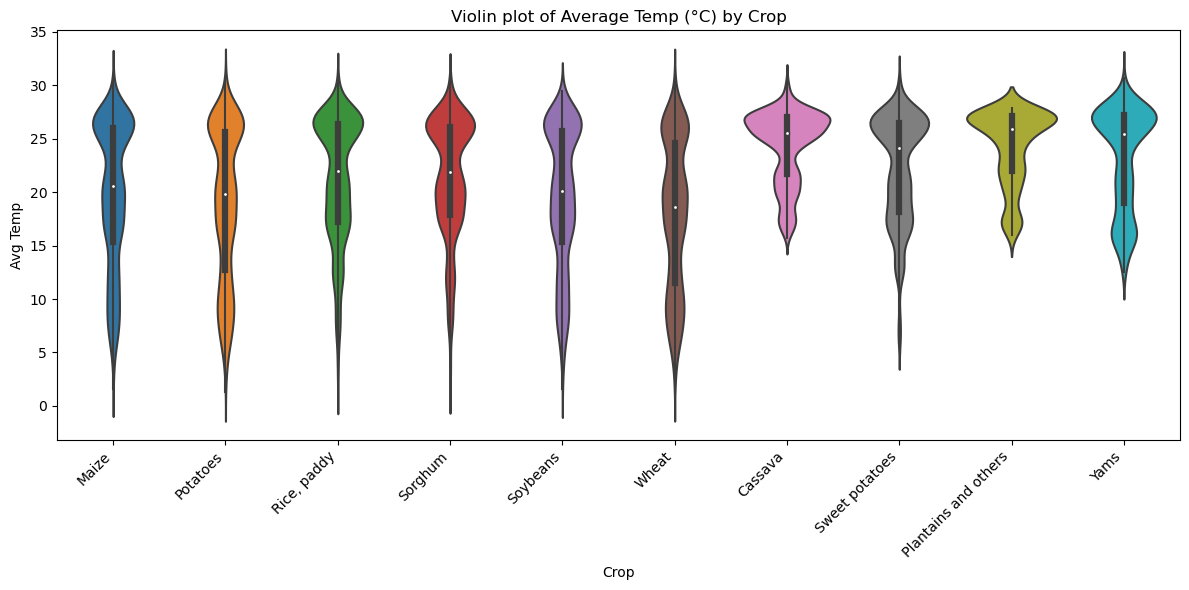

In [4]:
# Pesticides violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=yield_df, x='Crop', y='Pesticide Tonnes')
plt.title('Violin plot of Pesticide Tonnes by Crop')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Temp violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=yield_df, x='Crop', y='Avg Temp')
plt.title('Violin plot of Average Temp (°C) by Crop')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Preparation for Modeling
This section focuses on preparing the data for model training. It involves encoding categorical variables, splitting the dataset into training and test sets, and other preprocessing steps.


In [5]:
yield_df['Year'] = yield_df['Year'].astype(int)

# Identify categorical and numerical columns
categorical_cols = ['Country', 'Crop']
numerical_cols = ['Year', 'Pesticide Tonnes', 'Avg Temp']

# Separate target variable (y) and features (x)
X = yield_df[categorical_cols + numerical_cols]
y = yield_df['Hg/Ha Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model Training
This section sets up the machine learning pipeline and trains a Random Forest Regressor model on the prepared dataset. The time taken to train the model is also tracked.




In [6]:
# Set up column transfer for cat and num data
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Create pipeline with preprocessing and the RF model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=125, random_state=42))])

# Model fitting
start_time = time.time()
model.fit(X_train, y_train)
duration = time.time() - start_time
print(f'Time to train the model: {duration:.4f} seconds')

Time to train the model: 30.9842 seconds


## Model Evaluation
After training, the mode's performance is evaluated using metrics like R-squared and cross-validation scores. Additionally, a visualization of the model's predictions compared to the actual values is provided.


In [7]:
# Test set prediction
y_pred = model.predict(X_test)

# Cross-validation
start_time = time.time()
cv_scores = cross_val_score(model, X_train, y_train, cv=3) # cv set to 3 to keep time down
duration = time.time() - start_time

# Cross-validation mean score
cv_mean = cv_scores.mean()
# # Calculate r-squared
test_r2 = r2_score(y_test, y_pred)

# Prepare a dataframe to display values
results_df = pd.DataFrame({
    'Metric': ['Mean CV R-squared', 'Test R-squared', 'Cross-Validation Computation Time'],
    'Value': [f'{cv_mean:.2f}', f'{test_r2:.2f}', f'{duration:.4f} seconds']
})

# Display results
results_df

,Metric,Value
0,Mean CV R-squared,0.98
1,Test R-squared,0.99
2,Cross-Validation Computation Time,53.7159 seconds


#### Actual Values vs. Predicted Yield Values

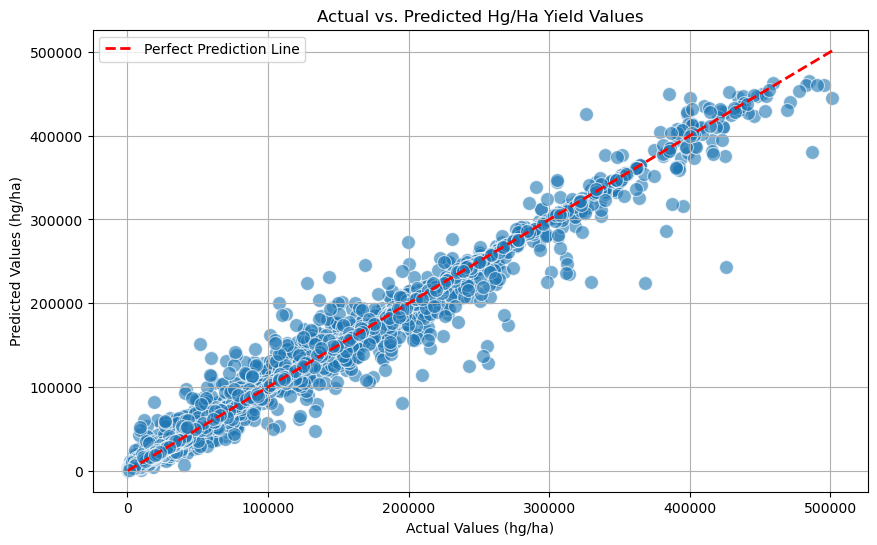

In [8]:
# Scatter plot based on the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=100)  # s is the marker size
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values (hg/ha)')
plt.ylabel('Predicted Values (hg/ha)')
plt.title('Actual vs. Predicted Hg/Ha Yield Values')
plt.legend()
plt.grid(True)
plt.show()

## User Interface for Predictions
The final section includes an interactive user interface, created using ipywidgets, enabling users to input data and receive yield predictions from the trained model<br><br>
**Please note: The message below will update with recommended value ranges per country. <br>
Numbers beyond the recommended range will lead to inaccurate predictions due to other environmental factors**..

In [9]:
def create_dropdown(label, options, description_width='180px'):
    dropdown = widgets.Dropdown(options=options)
    label_widget = widgets.Label(label)
    label_widget.layout.width = description_width
    return widgets.HBox([label_widget, dropdown])

def create_float_text(label, initial_value=0.0, description_width='180px'):
    text_box = widgets.FloatText(value=initial_value)
    label_widget = widgets.Label(label)
    label_widget.layout.width = description_width
    return widgets.HBox([label_widget, text_box])

def setup_range_message(yield_df):
    country_ranges = yield_df.groupby('Country').agg({
        'Pesticide Tonnes': ['min', 'max'],
        'Avg Temp': ['min', 'max']
    }).to_dict()
    return country_ranges, widgets.Label()

def update_crop_options(yield_df, country_widget, crop_widget, range_message, country_ranges):
    def update_crops(*args):
        country = country_widget.value
        available_crops = sorted(yield_df[yield_df['Country'] == country]['Crop'].unique()) # updates crop dropdown per country
        crop_widget.options = available_crops
        
        pesticide_min = country_ranges[('Pesticide Tonnes', 'min')][country]
        pesticide_max = country_ranges[('Pesticide Tonnes', 'max')][country]
        temp_min = country_ranges[('Avg Temp', 'min')][country]
        temp_max = country_ranges[('Avg Temp', 'max')][country]
        range_message.value = (f"For pesticides, select between {pesticide_min} and {pesticide_max} tonnes. "
                               f"For Avg Temp, enter {temp_min} and {temp_max} °C.")
    country_widget.observe(update_crops, 'value')
    update_crops()  # Initialize with the default selection

def predict_and_display_output(model, country_widget, crop_widget, pesticide_widget, temp_widget, output):
    def on_predict_btn_clicked(b):
        with output:
            output.clear_output()
            years_to_predict = range(yield_df['Year'].min(), yield_df['Year'].max() + 1)
            predictions = [model.predict(pd.DataFrame({
                'Country': [country_widget.value],
                'Crop': [crop_widget.value],
                'Year': [year],
                'Pesticide Tonnes': [pesticide_widget.value],
                'Avg Temp': [temp_widget.value],
            }))[0] for year in years_to_predict]
            avg_prediction = sum(predictions) / len(predictions)
            print(f'Average Predicted Annual Crop Yield (hg/ha): {avg_prediction:.2f}')
    return on_predict_btn_clicked

def initialize_ui(yield_df, model):
    # Initialize widgets
    initial_country = yield_df['Country'].unique()[0]
    initial_crops = sorted(yield_df[yield_df['Country'] == initial_country]['Crop'].unique())
    
    country_widget = create_dropdown('Country:', yield_df['Country'].unique())
    crop_widget = create_dropdown('Crop:', initial_crops)
    pesticide_widget = create_float_text('Pesticide (tonnes):')
    temp_widget = create_float_text('Average Temperature (°C):')
    
    country_ranges, range_message = setup_range_message(yield_df)
    update_crop_options(yield_df, country_widget.children[1], crop_widget.children[1], range_message, country_ranges)
    
    predict_btn = widgets.Button(description='Predict Yield')
    output = widgets.Output()
    predict_btn.on_click(predict_and_display_output(model, country_widget.children[1], crop_widget.children[1], pesticide_widget.children[1], temp_widget.children[1], output))
    
    # Layout and display the UI components
    display(country_widget, crop_widget, range_message, pesticide_widget, temp_widget, predict_btn, output)

    
initialize_ui(yield_df, model)

Label(value='For pesticides, select between 121.0 and 1311.17 tonnes. For Avg Temp, enter 15.36 and 17.41 °C.'…

Button(description='Predict Yield', style=ButtonStyle())

Output()